# Custom CNN for Driver Distraction Detection (Advanced Architecture)

This notebook implements an enhanced Convolutional Neural Network (CNN) for driver distraction classification using the filtered 3-class dataset.

Improvements over the baseline:
- Deeper architecture with more convolutional layers
- Use of Batch Normalization and DropBlock (if implemented)
- Regularization via L2 penalty
- Potential use of residual connections and attention (optional)

Goals:
- Improve classification performance compared to the baseline
- Handle class imbalance and generalize better on unseen data


### 1. Import Required Libraries
We import TensorFlow, Keras layers, optimizers, and evaluation metrics, along with any custom components like DropBlock and residual connections if used.


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    average_precision_score, f1_score, balanced_accuracy_score
)
import random
# Setting global seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


### 2. Set Hyperparameters and Paths
We define key hyperparameters such as image size, batch size, number of classes, paths to data directories and metadata CSV files.


In [ ]:
# Paths
train_csv = '../split_data/training_data.csv'
val_csv = '../split_data/validation_data.csv'
test_csv = '../split_data/testing_data.csv'

train_dir = '../split_data/training'
val_dir = '../split_data/validation'
test_dir = '../split_data/testing'

# Loading CSVs
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Defining class label order
target_classes = ['safe_driving', 'using_phone', 'drinking']


### 3. Define Data Generators
We prepare `ImageDataGenerator` instances for training (with augmentation) and for validation/testing (with rescaling only).


In [ ]:


# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Base directory and CSVs
base_dir = "../split_data"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)


target_classes = ['safe_driving', 'using_phone', 'drinking']
# Validation and test generators only have rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "training_data.csv")),
    directory=os.path.join(base_dir, "training"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED,
    classes=target_classes
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "validation_data.csv")),
    directory=os.path.join(base_dir, "validation"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=target_classes
)

# Testing generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "testing_data.csv")),
    directory=os.path.join(base_dir, "testing"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=target_classes
)


Found 8442 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.


### 4. Load Image Data via DataFrame
We load the training, validation, and test datasets using `flow_from_dataframe` to generate batches of images and labels from CSV metadata.
We also compute balanced class weights

In [ ]:


# Defining the correct mapping
label_map = {
    'safe_driving': 0,
    'using_phone': 1,
    'drinking': 2
}

# Loading the training labels and mapping them correctly
df_train = pd.read_csv(os.path.join(base_dir, "training_data.csv"))
y_train_str = df_train["class_id"]
y_train = y_train_str.map(label_map)  # Convert string to int labels: 0/1/2

# Checking if any NaNs occurred due to unmapped labels
if y_train.isnull().any():
    print("Unmapped labels found in y_train!")
    print(y_train_str[ y_train.isnull() ].unique())

# computing class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=y_train
)

# Converting to dict for Keras
class_weights = dict(zip([0, 1, 2], class_weights))
print("Corrected class weights:", class_weights)


Corrected class weights: {0: 1.884795713328868, 1: 0.5066618653222903, 2: 2.0172043010752687}


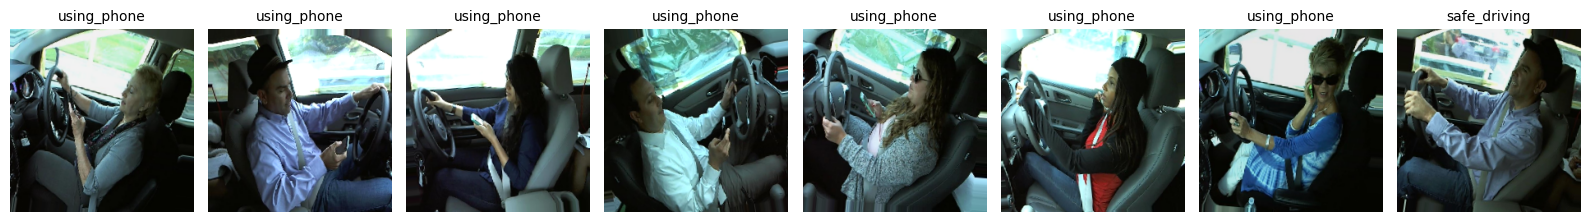

In [5]:


# Getting one batch of augmented images and labels
images, labels = next(train_generator)

# Plot the first 8 images from the batch
plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


### 5. Define Custom CNN Architecture
We build a deeper CNN with advanced features like Batch Normalization, L2 regularization, and optionally DropBlock or residual connections.
We compile the model using Adam optimizer and categorical crossentropy loss. We also track accuracy, precision, and recall during training.

In [ ]:
#custom CNN architecture
custom_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # intermediate softer layer (addition from baseline)
    Conv2D(96, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global feature pooling
    GlobalAveragePooling2D(),

    # Dense + Regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.4),

    # Output
    Dense(3, activation='softmax')
])

# Compiling the model
custom_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("custom_cnn_model", monitor='val_accuracy', save_best_only=True, save_format='tf')
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,    # cut LR in half when val_loss stalls
    patience=2,    # waiting 2 bad epochs before reducing LR
    verbose=1,
    min_lr=1e-6
)


custom_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

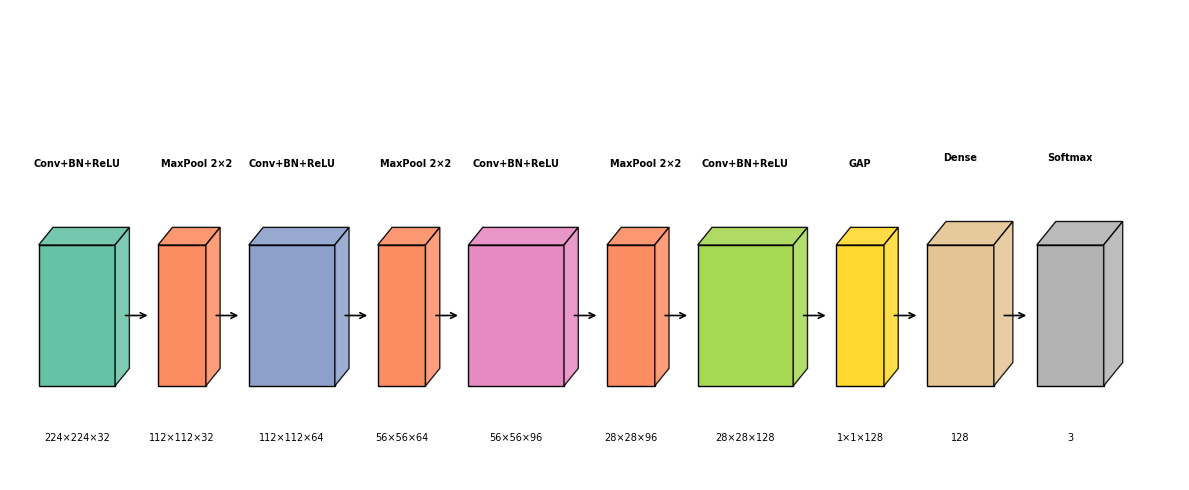

In [ ]:

# Function to plot blocks for CNN Architecture
def draw_block(ax, pos, size, color, label_top, label_bottom, bold=False, shift_top_x=0):
    x, y = pos
    dx, dy, dz = size
    front = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='k', facecolor=color)
    ax.add_patch(front)
    top = patches.Polygon([[x, y+dy], [x+dz, y+dy+dz], [x+dx+dz, y+dy+dz], [x+dx, y+dy]],
                          closed=True, linewidth=1, edgecolor='k', facecolor=color, alpha=0.9)
    ax.add_patch(top)
    side = patches.Polygon([[x+dx, y], [x+dx+dz, y+dz], [x+dx+dz, y+dy+dz], [x+dx, y+dy]],
                           closed=True, linewidth=1, edgecolor='k', facecolor=color, alpha=0.85)
    ax.add_patch(side)
    fw = 'bold' if bold else 'normal'
    ax.text(x + dx/2 + shift_top_x, y + dy + dz + 0.5, label_top,
            ha='center', va='bottom', fontsize=7, fontweight=fw)
    ax.text(x + dx/2, y - 0.4, label_bottom,
            ha='center', va='top', fontsize=7)
    return x + dx + dz

# Function to plot the cnn architecture
def plot_custom_cnn_architecture(save_path=None):
    layers = [
        ((0.8, 1.2, 0.15), '#66c2a5', 'Conv+BN+ReLU', '224×224×32', True),
        ((0.5, 1.2, 0.15), '#fc8d62', 'MaxPool 2×2', '112×112×32', True),
        ((0.9, 1.2, 0.15), '#8da0cb', 'Conv+BN+ReLU', '112×112×64', True),
        ((0.5, 1.2, 0.15), '#fc8d62', 'MaxPool 2×2', '56×56×64', True),
        ((1.0, 1.2, 0.15), '#e78ac3', 'Conv+BN+ReLU', '56×56×96', True),
        ((0.5, 1.2, 0.15), '#fc8d62', 'MaxPool 2×2', '28×28×96', True),
        ((1.0, 1.2, 0.15), '#a6d854', 'Conv+BN+ReLU', '28×28×128', True),
        ((0.5, 1.2, 0.15), '#ffd92f', 'GAP', '1×1×128', True),
        ((0.7, 1.2, 0.20), '#e5c494', 'Dense', '128', True),
        ((0.7, 1.2, 0.20), '#b3b3b3', 'Softmax', '3', True),
    ]

    fig, ax = plt.subplots(figsize=(12, 5))
    x = 0.0
    spacing = 0.45
    rightmost = -1e9

    # Drawing layers
    fronts_right_edges = []
    for (size, color, top, bottom, bold) in layers:
        shift = 0.15 if "MaxPool" in top else 0
        right_edge = draw_block(ax, (x, 0), size, color, top, bottom, bold, shift_top_x=shift)
        fronts_right_edges.append(x + size[0])  # for arrows
        x = fronts_right_edges[-1] + spacing
        rightmost = max(rightmost, right_edge)

    # Arrows between blocks 
    arrow_y = 0.6
    x_front = 0.0
    for i in range(len(layers)-1):
        curr_front_right = fronts_right_edges[i]
        next_front_left  = fronts_right_edges[i] + spacing
        ax.annotate('', xy=(next_front_left-0.08, arrow_y),
                    xytext=(curr_front_right+0.08, arrow_y),
                    arrowprops=dict(arrowstyle='->', lw=1.2))

    # defingin margins and axis limits
    left_margin = -0.3
    right_margin = 0.6
    ax.set_xlim(left_margin, rightmost + right_margin)
    ax.set_ylim(-0.8, 3.2)
    ax.axis('off')

    # Adding padding so bbox doesn't crop shadows/labels
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.2, transparent=True)
    plt.tight_layout()
    plt.show()

plot_custom_cnn_architecture("custom_cnn_diagram.png")



### 6. Train the Custom CNN Model
We fit the model on the training data using class weights to balance underrepresented classes, and validate it on the validation set.


In [7]:
history = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    class_weight=class_weights
)
custom_model.save("custom_cnn_model", save_format='tf')



Epoch 1/25
264/264 [==============================] - ETA: 0s - loss: 1.1556 - accuracy: 0.4768

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 275s 1s/step - loss: 1.1556 - accuracy: 0.4768 - val_loss: 1.1960 - val_accuracy: 0.3962 - lr: 5.0000e-04
Epoch 2/25
264/264 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.6896

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 262s 990ms/step - loss: 0.7425 - accuracy: 0.6896 - val_loss: 1.0152 - val_accuracy: 0.5988 - lr: 5.0000e-04
Epoch 3/25
264/264 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.8240

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 309s 1s/step - loss: 0.5093 - accuracy: 0.8240 - val_loss: 0.6082 - val_accuracy: 0.7982 - lr: 5.0000e-04
Epoch 4/25
264/264 [==============================] - 259s 981ms/step - loss: 0.3662 - accuracy: 0.8928 - val_loss: 3.5432 - val_accuracy: 0.2811 - lr: 5.0000e-04
Epoch 5/25
264/264 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9215

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 269s 1s/step - loss: 0.2965 - accuracy: 0.9215 - val_loss: 0.4195 - val_accuracy: 0.8984 - lr: 5.0000e-04
Epoch 6/25
264/264 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9443

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 365s 1s/step - loss: 0.2394 - accuracy: 0.9443 - val_loss: 0.3620 - val_accuracy: 0.9126 - lr: 5.0000e-04
Epoch 7/25
264/264 [==============================] - 257s 973ms/step - loss: 0.1933 - accuracy: 0.9569 - val_loss: 1.9581 - val_accuracy: 0.4733 - lr: 5.0000e-04
Epoch 8/25
264/264 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9626
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
264/264 [==============================] - 259s 979ms/step - loss: 0.1755 - accuracy: 0.9626 - val_loss: 0.4163 - val_accuracy: 0.8618 - lr: 5.0000e-04
Epoch 9/25
264/264 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9796

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 261s 988ms/step - loss: 0.1278 - accuracy: 0.9796 - val_loss: 0.1426 - val_accuracy: 0.9712 - lr: 2.5000e-04
Epoch 10/25
264/264 [==============================] - 417s 2s/step - loss: 0.1154 - accuracy: 0.9822 - val_loss: 0.3870 - val_accuracy: 0.8859 - lr: 2.5000e-04
Epoch 11/25
264/264 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9845
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
264/264 [==============================] - 417s 2s/step - loss: 0.1044 - accuracy: 0.9845 - val_loss: 0.9283 - val_accuracy: 0.6720 - lr: 2.5000e-04
Epoch 12/25
264/264 [==============================] - 395s 1s/step - loss: 0.0930 - accuracy: 0.9890 - val_loss: 0.1781 - val_accuracy: 0.9527 - lr: 1.2500e-04
Epoch 13/25
264/264 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9906

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 392s 1s/step - loss: 0.0844 - accuracy: 0.9906 - val_loss: 0.1260 - val_accuracy: 0.9730 - lr: 1.2500e-04
Epoch 14/25
264/264 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9898

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 316s 1s/step - loss: 0.0859 - accuracy: 0.9898 - val_loss: 0.0831 - val_accuracy: 0.9908 - lr: 1.2500e-04
Epoch 15/25
264/264 [==============================] - 405s 2s/step - loss: 0.0773 - accuracy: 0.9927 - val_loss: 0.1187 - val_accuracy: 0.9751 - lr: 1.2500e-04
Epoch 16/25
264/264 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9932
Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
264/264 [==============================] - 411s 2s/step - loss: 0.0710 - accuracy: 0.9932 - val_loss: 0.0930 - val_accuracy: 0.9844 - lr: 1.2500e-04
Epoch 17/25
264/264 [==============================] - 399s 2s/step - loss: 0.0651 - accuracy: 0.9938 - val_loss: 0.0725 - val_accuracy: 0.9908 - lr: 6.2500e-05
Epoch 18/25
264/264 [==============================] - 386s 1s/step - loss: 0.0638 - accuracy: 0.9947 - val_loss: 0.0779 - val_accuracy: 0.9897 - lr: 6.2500e-05
Epoch 19/25
264/264 [=========================

INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


264/264 [==============================] - 351s 1s/step - loss: 0.0551 - accuracy: 0.9960 - val_loss: 0.0661 - val_accuracy: 0.9915 - lr: 1.5625e-05
Epoch 25/25
264/264 [==============================] - 299s 1s/step - loss: 0.0544 - accuracy: 0.9963 - val_loss: 0.0677 - val_accuracy: 0.9911 - lr: 1.5625e-05


INFO:tensorflow:Assets written to: custom_cnn_model\assets


INFO:tensorflow:Assets written to: custom_cnn_model\assets


### 7. Evaluate Custom CNN on Test Data
We evaluate the final model on the unseen test dataset and print the performance metrics to assess generalization.
We generate predictions on test data and output a classification report and confusion matrix to analyze class-wise model performance.


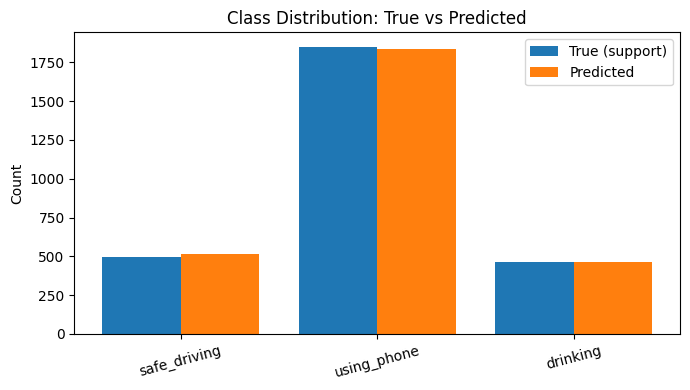

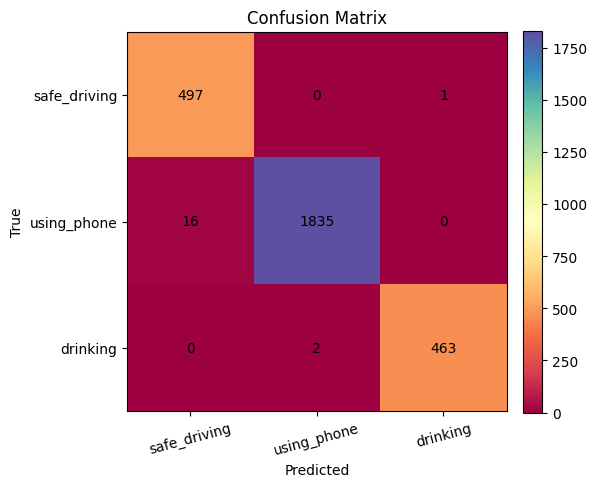

              precision    recall  f1-score   support

safe_driving      0.969     0.998     0.983       498
 using_phone      0.999     0.991     0.995      1851
    drinking      0.998     0.996     0.997       465

    accuracy                          0.993      2814
   macro avg      0.989     0.995     0.992      2814
weighted avg      0.993     0.993     0.993      2814

Macro F1: 0.992  |  Micro F1: 0.993  |  Balanced Accuracy: 0.995


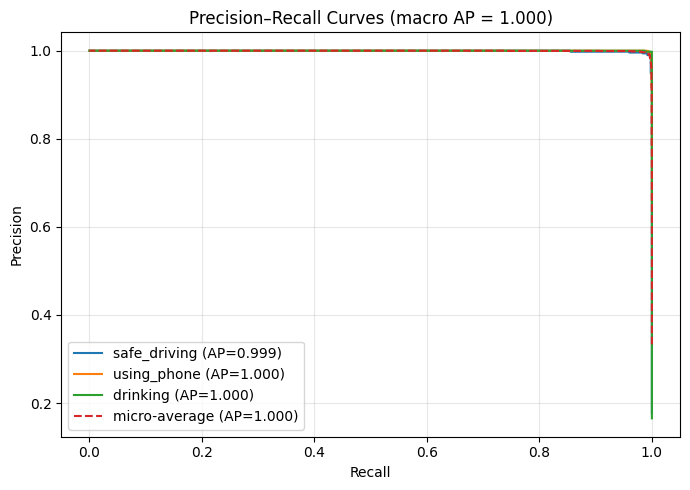

Average Precision per class: {'safe_driving': 0.9994584119239476, 'using_phone': 0.9999222012370401, 'drinking': 0.9999721609471607}
Micro AP: 0.9996022389848733  | Macro AP: 0.9997842580360494


In [ ]:

# Loading model and predicting on test set
model = tf.keras.models.load_model("custom_cnn_model") 
test_generator.shuffle = False
test_generator.reset()

y_score = model.predict(test_generator, verbose=0)      
y_pred  = np.argmax(y_score, axis=1)
y_true  = test_generator.classes

class_names   = list(test_generator.class_indices.keys())
idx_to_class  = {v:k for k,v in test_generator.class_indices.items()}
n_classes     = len(class_names)

# Class distribution counters for explaining imbalance
true_counts = Counter(y_true)
pred_counts = Counter(y_pred)

plt.figure(figsize=(7,4))
x = np.arange(n_classes)
plt.bar(x - 0.2, [true_counts[i] for i in range(n_classes)], width=0.4, label="True (support)")
plt.bar(x + 0.2, [pred_counts[i] for i in range(n_classes)], width=0.4, label="Predicted")
plt.xticks(x, [idx_to_class[i] for i in range(n_classes)], rotation=15)
plt.ylabel("Count")
plt.title("Class Distribution: True vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting Confusion matrix 
cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
plt.figure(figsize=(5.8,5))
im = plt.imshow(cm, interpolation='nearest',cmap="Spectral")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n_classes), [idx_to_class[i] for i in range(n_classes)], rotation=15)
plt.yticks(range(n_classes), [idx_to_class[i] for i in range(n_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# Classification report 
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Macro/micro summaries 
macro_f1   = f1_score(y_true, y_pred, average="macro")
micro_f1   = f1_score(y_true, y_pred, average="micro")
bal_acc    = balanced_accuracy_score(y_true, y_pred)
print(f"Macro F1: {macro_f1:.3f}  |  Micro F1: {micro_f1:.3f}  |  Balanced Accuracy: {bal_acc:.3f}")

# Precision–Recall curves + AU‑PR 
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(7,5))
ap_per_class = {}
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_score[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_score[:, i])
    ap_per_class[cls] = ap
    plt.plot(recall, precision, label=f"{cls} (AP={ap:.3f})")

# micro-average
prec_micro, rec_micro, _ = precision_recall_curve(y_true_onehot.ravel(), y_score.ravel())
ap_micro = average_precision_score(y_true_onehot, y_score, average="micro")
plt.plot(rec_micro, prec_micro, linestyle="--", label=f"micro-average (AP={ap_micro:.3f})")

# macro-average 
ap_macro = average_precision_score(y_true_onehot, y_score, average="macro")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curves (macro AP = {ap_macro:.3f})")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Average Precision per class:", ap_per_class)
print("Micro AP:", ap_micro, " | Macro AP:", ap_macro)



88/88 [==============================] - 19s 220ms/step


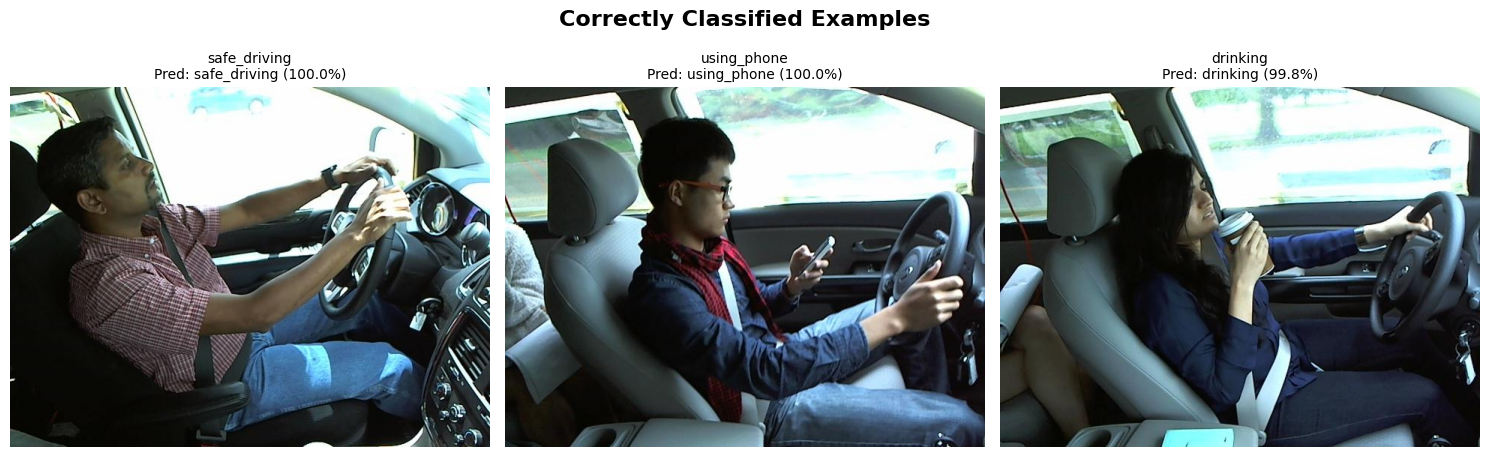

In [ ]:

test_generator.reset()

# Generating predictions
preds = model.predict(test_generator, verbose=1)

# Getting predicted labels and true labels
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Mapping class indices
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Extracting filepaths for test images
filepaths = test_generator.filepaths

# Extracting softmax confidence for each prediction
confidences = np.max(preds, axis=1)

# Test directory for loading original images
test_dir = "../split_data/testing"


# Function to plot one correct example per class
def plot_correct_examples(classes_list):
    fig, axes = plt.subplots(1, len(classes_list), figsize=(15, 5))
    fig.suptitle("Correctly Classified Examples", fontsize=16, fontweight='bold')

    for ax, class_name in zip(axes, classes_list):
        class_idx = class_indices[class_name]
        indices = np.where(np.array(y_true) == class_idx)[0]
        correct_indices = [i for i in indices if y_pred[i] == y_true[i]]

        if not correct_indices:
            ax.set_title(f"No correct example for {class_name}")
            ax.axis("off")
            continue

        selected_idx = random.choice(correct_indices)
        img_path = os.path.join(test_dir, os.path.basename(filepaths[selected_idx]))
        img = plt.imread(img_path)

        ax.imshow(img)
        ax.set_title(
            f"{class_name}\nPred: {idx_to_class[y_pred[selected_idx]]} ({confidences[selected_idx]*100:.1f}%)",
            fontsize=10
        )
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run for all three classes
plot_correct_examples(['safe_driving', 'using_phone', 'drinking'])


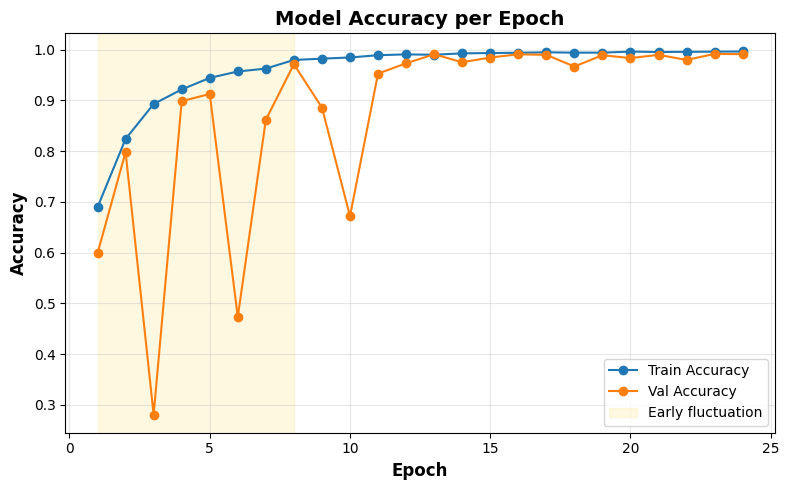

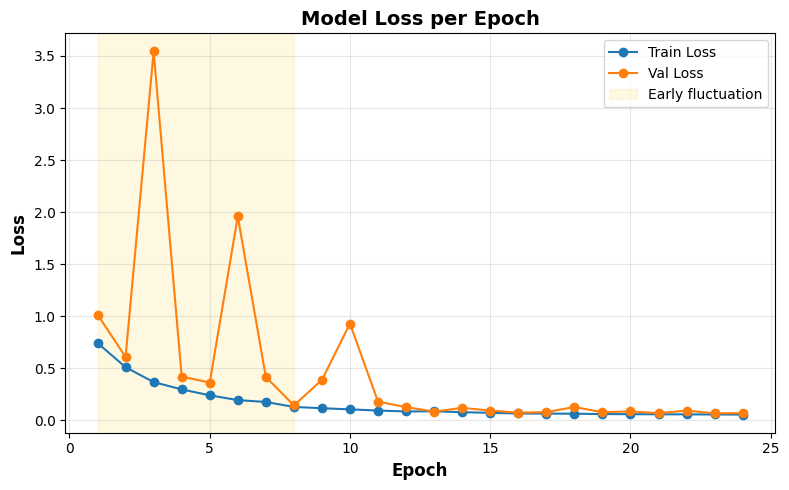

In [ ]:

train_acc = [
    0.6896, 0.8240, 0.8928, 0.9215, 0.9443, 0.9569, 0.9626, 0.9796, 0.9822,
    0.9845, 0.9890, 0.9906, 0.9898, 0.9927, 0.9932, 0.9938, 0.9947, 0.9940,
    0.9940, 0.9961, 0.9953, 0.9956, 0.9960, 0.9963
]
val_acc = [
    0.5988, 0.7982, 0.2811, 0.8984, 0.9126, 0.4733, 0.8618, 0.9712, 0.8859,
    0.6720, 0.9527, 0.9730, 0.9908, 0.9751, 0.9844, 0.9908, 0.9897, 0.9666,
    0.9890, 0.9833, 0.9897, 0.9797, 0.9915, 0.9911
]
train_loss = [
    0.7425, 0.5093, 0.3662, 0.2965, 0.2394, 0.1933, 0.1755, 0.1278, 0.1154,
    0.1044, 0.0930, 0.0844, 0.0859, 0.0773, 0.0710, 0.0651, 0.0638, 0.0627,
    0.0592, 0.0582, 0.0571, 0.0565, 0.0551, 0.0544
]
val_loss = [
    1.0152, 0.6082, 3.5432, 0.4195, 0.3620, 1.9581, 0.4163, 0.1426, 0.3870,
    0.9283, 0.1781, 0.1260, 0.0831, 0.1187, 0.0930, 0.0725, 0.0779, 0.1272,
    0.0772, 0.0850, 0.0682, 0.0927, 0.0661, 0.0677
]

epochs = np.arange(1, len(train_acc) + 1)

# Accuracy plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(epochs, train_acc, marker='o', label='Train Accuracy')
ax.plot(epochs, val_acc, marker='o', label='Val Accuracy')
ax.axvspan(1, 8, alpha=0.25, color="#fde68a", label="Early fluctuation")
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax.set_title("Model Accuracy per Epoch", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Loss plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(epochs, train_loss, marker='o', label='Train Loss')
ax.plot(epochs, val_loss, marker='o', label='Val Loss')
ax.axvspan(1, 8, alpha=0.25, color="#fde68a", label="Early fluctuation")
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Loss", fontsize=12, fontweight='bold')
ax.set_title("Model Loss per Epoch", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
